<a href="https://colab.research.google.com/github/m3llad0/TC3007C/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from zipfile import ZipFile
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization , MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow

In [25]:
#Download the dataset from kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

with ZipFile('chest-ctscan-images.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

!rm chest-ctscan-images.zip


 91% 108M/119M [00:00<00:00, 133MB/s] 
100% 119M/119M [00:00<00:00, 132MB/s]


## Preprocesamiento de datos



In [26]:
train_data_dir = './Data/train'
test_data_dir = './Data/test'
validation_data_dir = './Data/valid'

In [73]:
input_size = (460, 460)

training_datagen = ImageDataGenerator(dtype='float32',)
test_datagen = ImageDataGenerator( dtype='float32')
validation_datagen = ImageDataGenerator( dtype='float32')

# Load and preprocess training data
train_generator = training_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_size,
    batch_size=16,
    class_mode='categorical')

# Load and preprocess testing data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=input_size,
    batch_size=16,
    class_mode='categorical')

# Load and preprocess validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=input_size,
    batch_size=16,
    class_mode='categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


## Construcción del modelo

El modelo se construyó utilizando como base


In [28]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(include_top=False,
                      pooling='avg',
                      weights='imagenet',
                      input_shape = (460, 460, 3))

for layer in base_model.layers:
  if 'conv5' not in layer.name:
    layer.trainable = False

In [29]:
model = tensorflow.keras.models.Sequential()
num_classes = len(train_generator.class_indices)

model.add(base_model)
model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [49]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(verbose = 1,
                               patience = 5,
                               restore_best_weights = True)
epochs = 100
history = model.fit(
    train_generator,
    verbose = 1,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])



Epoch 1/100
20/20 [==============================] - 38s 2s/step - loss: 0.5718 - accuracy: 0.7993 - val_loss: 15.2319 - val_accuracy: 0.5139
Epoch 2/100
20/20 [==============================] - 38s 2s/step - loss: 0.4825 - accuracy: 0.8271 - val_loss: 18.6550 - val_accuracy: 0.4306
Epoch 3/100
20/20 [==============================] - 38s 2s/step - loss: 0.4823 - accuracy: 0.8173 - val_loss: 75.9629 - val_accuracy: 0.2500
Epoch 4/100
20/20 [==============================] - 39s 2s/step - loss: 0.3725 - accuracy: 0.8613 - val_loss: 10.4774 - val_accuracy: 0.5000
Epoch 5/100
20/20 [==============================] - 39s 2s/step - loss: 0.3213 - accuracy: 0.8809 - val_loss: 1.8124 - val_accuracy: 0.7361
Epoch 6/100
20/20 [==============================] - 39s 2s/step - loss: 0.2726 - accuracy: 0.9103 - val_loss: 1.7794 - val_accuracy: 0.7361
Epoch 7/100
20/20 [==============================] - 37s 2s/step - loss: 0.2099 - accuracy: 0.9266 - val_loss: 2.3831 - val_accuracy: 0.7083
Epoch 8/1

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                      

In [51]:
model.evaluate(test_generator)

10/10 [==============================] - 5s 436ms/step - loss: 0.9867 - accuracy: 0.7556


[0.986700713634491, 0.7555555701255798]

Text(0.5, 1.0, 'Training and Validation Accuracy over Epochs')

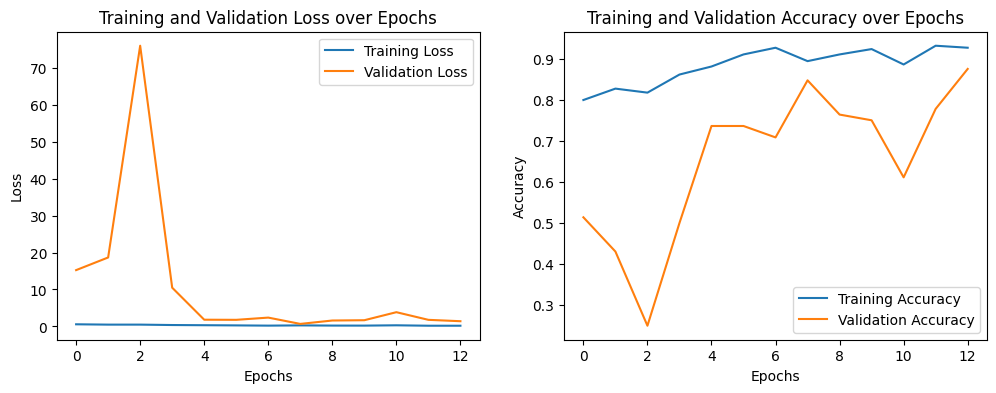

In [52]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')

10/10 [==============================] - 6s 615ms/step


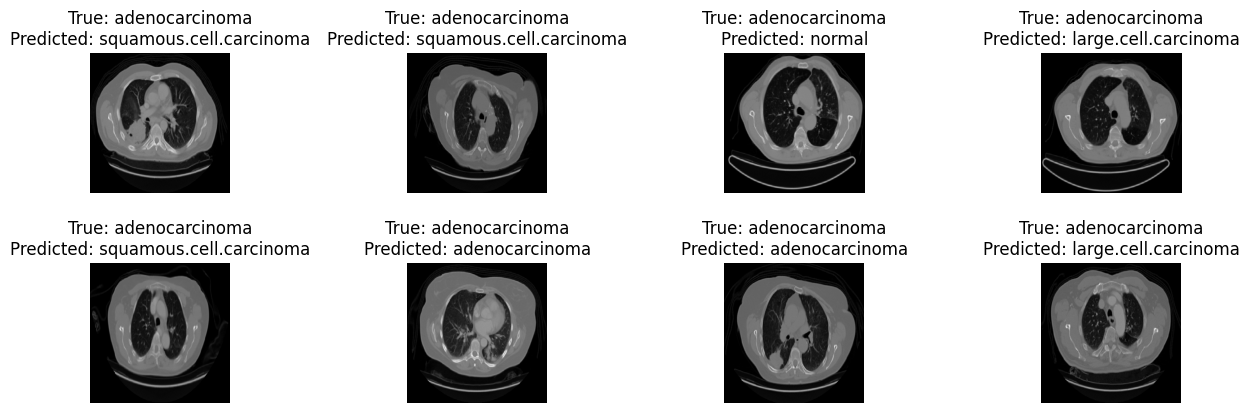

In [70]:
sample_images, _ = next(test_generator)

# Generar predicciones en el conjunto de datos de prueba
predictions = model.predict(test_generator)

# Obtener las etiquetas reales y predichas
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Mostrar las imágenes con etiquetas reales y predichas
plt.figure(figsize=(15, 10))
for i in range(8):  # Muestra las primeras 16 imágenes
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i]/255)
    plt.title(f"True: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
    plt.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Ajusta el espacio vertical y horizontal entre subgráficos


[[34 39 21 26]
 [13 20  6 12]
 [15 20 12  7]
 [34 30 12 14]]


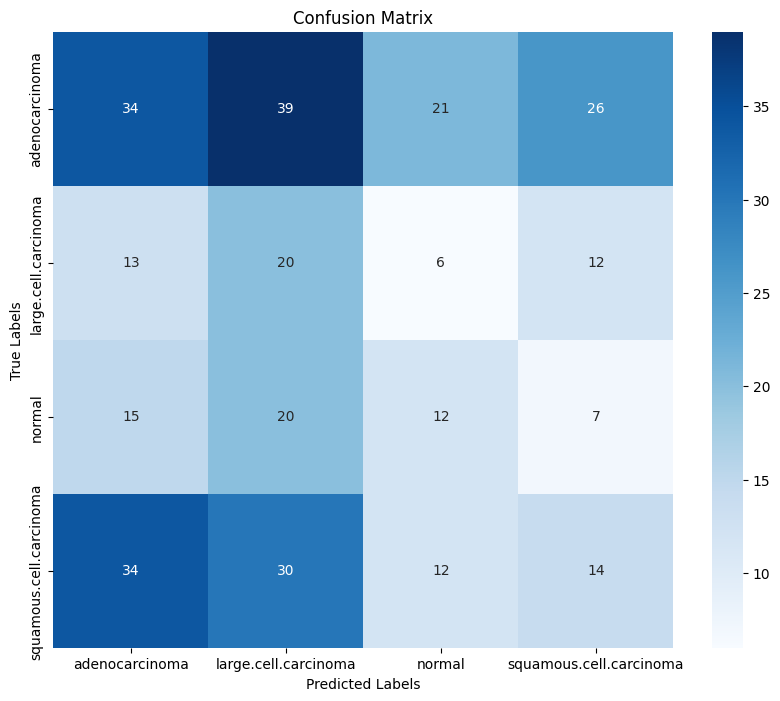

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Obtener etiquetas de clases para visualización
class_labels = list(test_generator.class_indices.keys())

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Ajuste de modelo

In [59]:
model_ajusted = tensorflow.keras.models.Sequential()
num_classes = len(train_generator.class_indices)

model_ajusted.add(base_model)
model_ajusted.add(Dropout(0.5))
model_ajusted.add(Flatten())
model_ajusted.add(BatchNormalization())
model_ajusted.add(Dropout(0.5))
model_ajusted.add(Dense(num_classes, activation='softmax'))

In [60]:
model_ajusted.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [71]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(verbose = 1,
                               patience = 5,)
epochs = 100
history_ajusted = model_ajusted.fit(
    train_generator,
    verbose = 1,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping])



Epoch 1/100
20/20 [==============================] - 52s 3s/step - loss: 0.0992 - accuracy: 0.9641 - val_loss: 0.6545 - val_accuracy: 0.8611
Epoch 2/100
20/20 [==============================] - 37s 2s/step - loss: 0.0927 - accuracy: 0.9706 - val_loss: 0.7757 - val_accuracy: 0.8750
Epoch 3/100
20/20 [==============================] - 37s 2s/step - loss: 0.1100 - accuracy: 0.9674 - val_loss: 0.6862 - val_accuracy: 0.8750
Epoch 4/100
20/20 [==============================] - 37s 2s/step - loss: 0.1139 - accuracy: 0.9527 - val_loss: 0.6861 - val_accuracy: 0.9167
Epoch 5/100
20/20 [==============================] - 39s 2s/step - loss: 0.1830 - accuracy: 0.9413 - val_loss: 1.0940 - val_accuracy: 0.8889
Epoch 6/100
20/20 [==============================] - 41s 2s/step - loss: 0.1121 - accuracy: 0.9576 - val_loss: 0.7849 - val_accuracy: 0.9167
Epoch 6: early stopping


In [74]:
model_ajusted.evaluate(test_generator)

20/20 [==============================] - 8s 293ms/step - loss: 0.3381 - accuracy: 0.9206


[0.3381045460700989, 0.920634925365448]

Text(0.5, 1.0, 'Training and Validation Accuracy over Epochs')

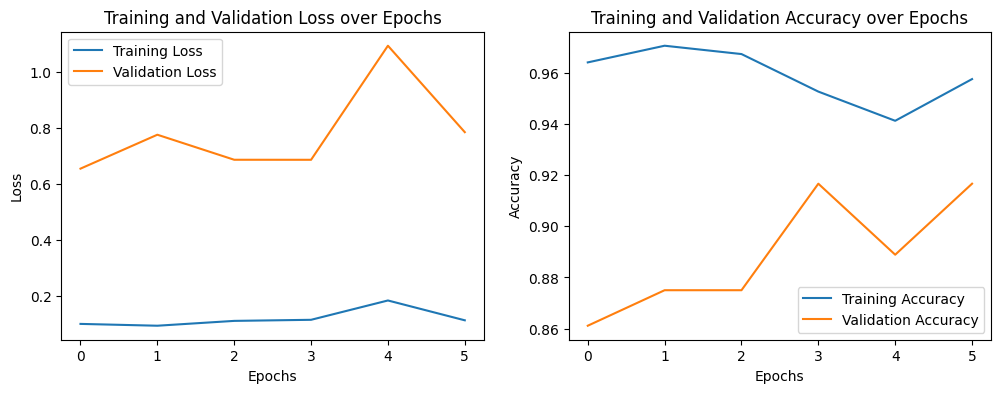

In [75]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_ajusted.history['loss'], label='Training Loss')
plt.plot(history_ajusted.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_ajusted.history['accuracy'], label='Training Accuracy')
plt.plot(history_ajusted.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over Epochs')

20/20 [==============================] - 6s 315ms/step


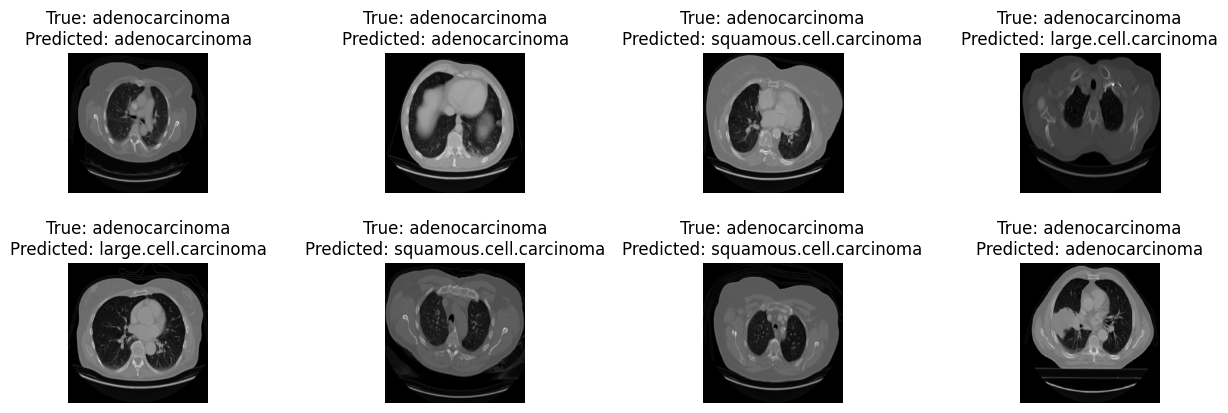

In [76]:
sample_images, _ = next(test_generator)

# Generar predicciones en el conjunto de datos de prueba
predictions = model_ajusted.predict(test_generator)

# Obtener las etiquetas reales y predichas
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)

class_labels = list(test_generator.class_indices.keys())

# Mostrar las imágenes con etiquetas reales y predichas
plt.figure(figsize=(15, 10))
for i in range(8):  # Muestra las primeras 16 imágenes
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i]/255)
    plt.title(f"True: {class_labels[true_labels[i]]}\nPredicted: {class_labels[predicted_labels[i]]}")
    plt.axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Ajusta el espacio vertical y horizontal entre subgráficos


[[45 28 16 31]
 [23  5 12 11]
 [22  7  8 17]
 [31 16 18 25]]


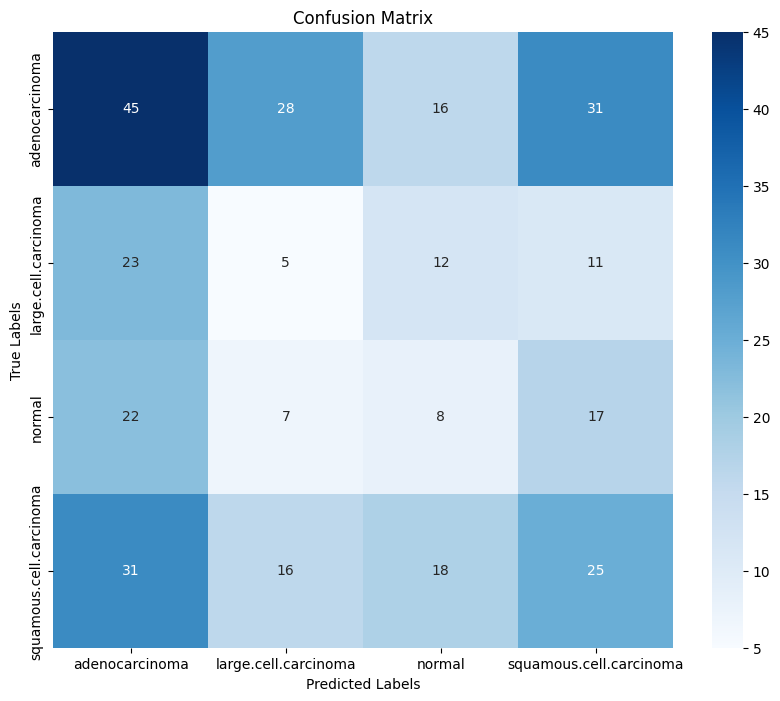

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Obtener etiquetas de clases para visualización
class_labels = list(test_generator.class_indices.keys())

# Crear un mapa de calor para visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()